<a href="https://colab.research.google.com/github/cypherix/dhyuthi/blob/master/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/ssd_person')

In [0]:
!wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar

--2018-10-20 11:18:13--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
           => ‘INRIAPerson.tar’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE INRIAPerson.tar ... 1016094720
==> PASV ... done.    ==> RETR INRIAPerson.tar ... done.
Length: 1016094720 (969M) (unauthoritative)

INRIAPerson.tar     100%[===================>] 969.02M  16.1MB/s    in 53s     

2018-10-20 11:19:07 (18.2 MB/s) - ‘INRIAPerson.tar’ saved [1016094720]



In [0]:
!tar xvf INRIAPerson.tar

INRIAPerson/
INRIAPerson/70X134H96/
INRIAPerson/70X134H96/Test/
INRIAPerson/70X134H96/Test/pos/
INRIAPerson/70X134H96/Test/pos/crop_000001a.png
INRIAPerson/70X134H96/Test/pos/crop_000001b.png
INRIAPerson/70X134H96/Test/pos/crop_000002a.png
INRIAPerson/70X134H96/Test/pos/crop_000002b.png
INRIAPerson/70X134H96/Test/pos/crop_000003a.png
INRIAPerson/70X134H96/Test/pos/crop_000003b.png
INRIAPerson/70X134H96/Test/pos/crop_000004a.png
INRIAPerson/70X134H96/Test/pos/crop_000004b.png
INRIAPerson/70X134H96/Test/pos/crop_000005a.png
INRIAPerson/70X134H96/Test/pos/crop_000005b.png
INRIAPerson/70X134H96/Test/pos/crop_000005c.png
INRIAPerson/70X134H96/Test/pos/crop_000005d.png
INRIAPerson/70X134H96/Test/pos/crop_000006a.png
INRIAPerson/70X134H96/Test/pos/crop_000006b.png
INRIAPerson/70X134H96/Test/pos/crop_000007a.png
INRIAPerson/70X134H96/Test/pos/crop_000007b.png
INRIAPerson/70X134H96/Test/pos/crop_000008a.png
INRIAPerson/70X134H96/Test/pos/crop_000008b.png
INRIAPerson/70X134H96/Test/pos/crop_0000

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [0]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
vgg16 = models.vgg16(pretrained=True)

In [0]:
vgg16.classifier._modules['6'] = nn.Linear(4096, 2)

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'INRIAPerson'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

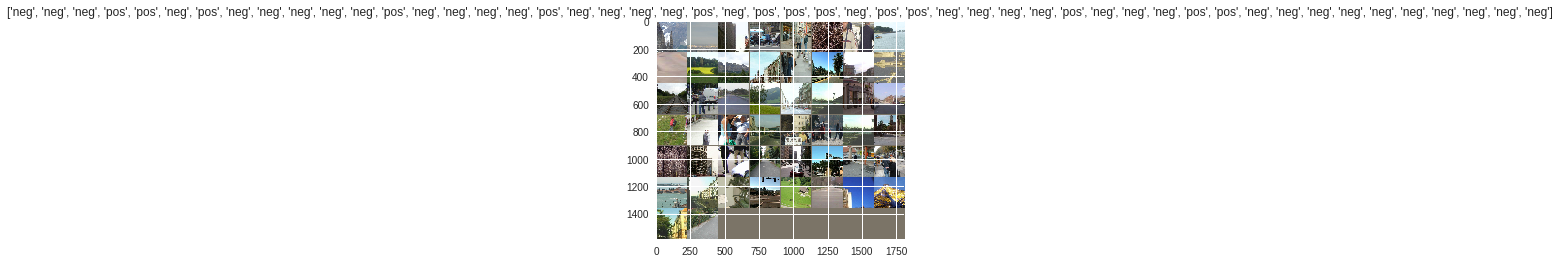

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
%matplotlib inline
!pip install --no-cache-dir -I Pillow

    100% |████████████████████████████████| 2.0MB 56.5MB/s 


In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.image

In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
